決定木
======

`アキネーター`というゲームを知っていますか？
このゲームは、プレイヤーが頭の中で考えたキャラクターや人物を、
一連の質問を通じて当てるというものです。
実は、このアキネーターの仕組みは、{index}`決定木<けっていぎ - 決定木>`という概念をよく表しています。

アキネーターの動作を細かく見てみましょう。

1. 「あなたが考えているのは実在の人物ですか？」といった基本的な質問から始まります。
2. プレイヤーの回答に応じて、次の質問が変わります。例えば、`はい`と答えれば「その人物は男性ですか？」、`いいえ`ならば「その存在はフィクションの世界のものですか？」といった具合です。
3. 各質問は、可能性のある答えの範囲を徐々に絞り込んでいきます。
4. このプロセスを繰り返し、最終的に一つの答えに辿り着きます。

このアキネーターの質問と回答のプロセスは、まさに決定木の構造そのものなのです。
各質問が木のノード（節点）となり、回答によって次のノードへと分岐していきます。
最終的に、木の葉に当たる部分で具体的な答えが得られます。

決定木も、基本的には同じ原理で動作します。
大量のデータから学習し、最も効率的に答えにたどり着ける質問（特徴）の順序を自動的に見つけ出すのです。
例えば、顧客が商品を購入するかどうかを予測する場合、「年齢は？」、「年収は？」、「過去の購買履歴は？」
といった質問を効率的に組み合わせて、最終的な予測を行います。

この方法のメリットは、結果が解釈しやすく、どのような基準で判断が行われたのかを明確に説明できることです。
また、線形回帰が直線（または超平面）でデータを近似するのに対し、決定木はデータを階層的に分割し、それぞれの領域で予測を行います。

決定木の主な特徴をまとめると以下の通りです。

- 特徴量の重要度を評価できる
- 解釈がしやすい
- 非線形の関係性を捉えられる

## 不純度（impurity）

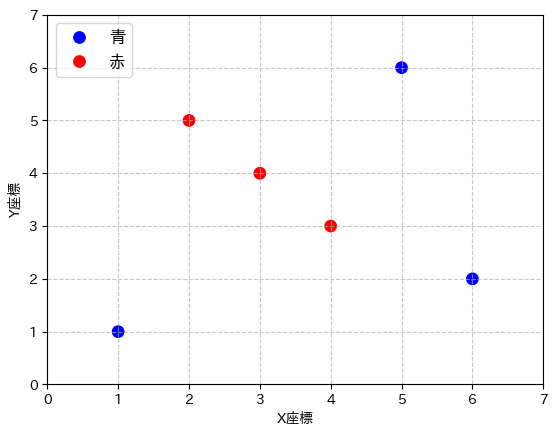

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

data = pd.DataFrame([
    (1, 1, '青'), (5, 6, '青'), (6, 2, '青'),
    (2, 5, '赤'), (3, 4, '赤'), (4, 3, '赤')
], columns=['x', 'y', '色'])

sns.scatterplot(data=data, x='x', y='y', hue='色', palette={'赤': 'red', '青': 'blue'}, s=100)

plt.xlabel('X座標')
plt.ylabel('Y座標')
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='', fontsize=12, loc='upper left')

plt.show()

このようにデータが散らばっていて、軸に並行な線を引いて赤と青の点を分離しようとします。
一本の線で分離はできず以下のように二本の線が必要になります。

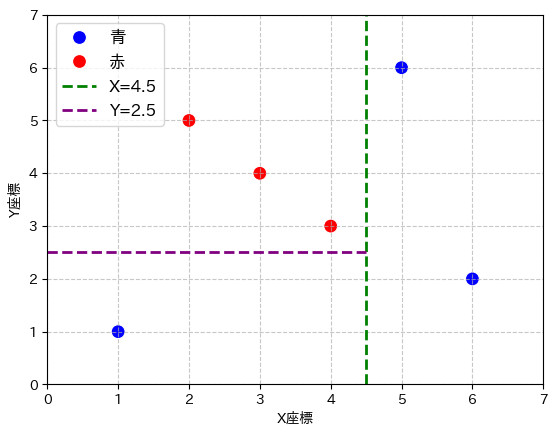

In [2]:
sns.scatterplot(data=data, x='x', y='y', hue='色', palette={'赤': 'red', '青': 'blue'}, s=100)

plt.axvline(x=4.5, color='green', linestyle='--', linewidth=2, label='X=4.5')
plt.plot([0, 4.5], [2.5, 2.5], color='purple', linestyle='--', linewidth=2, label='Y=2.5')

plt.xlabel('X座標')
plt.ylabel('Y座標')
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='', fontsize=12, loc='upper left')

plt.show()

データが赤かどうかを判別するには、$X \leq 4.5$の条件が成り立ち、かつ$Y \geq 2.5$の条件が成り立てば良いと言えます。

では、何を基準にしてこの条件を決めれば良いのでしょうか。

ここで不純度という考え方を導入します。
不純度は、集合内のデータがどれだけ混ざっているかを表す指標です。
つまり、不純度が小さいほどその集合はうまく分けられていると言えます。

不純度を計算する方法として**ジニ不純度**と**エントロピー**がよく使われます。

ジニ不純度は、ランダムに選んだデータが誤って分類される確率を表します。
値が小さいほど純度が高く、0に近いほど良いとされます。

ジニ不純度の計算式は
```{math}
\text{Gini} = 1 - \sum_{i=1}^{n} p_i^2
```
です。$p_i$はクラスiの確率です。

分ける前のジニ不純度は以下のように計算されます。

- 赤の確率: $p_{\text{赤}} = \displaystyle\frac{3}{6} = 0.5$
- 青の確率: $p_{\text{青}} = \displaystyle\frac{3}{6} = 0.5$

```{math}
\text{Gini} = 1 - (0.5^2 + 0.5^2) = 1 - 0.5 = 0.5
```

次に、$X=4.5$で分割した後の左側（$X \leq 4.5$）のジニ不純度を計算します。

- 赤の確率: $p_{\text{赤}} = \displaystyle\frac{3}{4} = 0.75$
- 青の確率: $p_{\text{青}} = \displaystyle\frac{1}{4} = 0.25$

ジニ不純度は$\text{Gini}_{\text{左}} = 1 - (0.75^2 + 0.25^2) = 1 - 0.625 = 0.375$となり、

右側（$X > 4.5$）のジニ不純度は

- 赤の確率: $p_{\text{赤}} = 0$
- 青の確率: $p_{\text{青}} = 1$

で、ジニ不純度は$\text{Gini}_{\text{右}} = 1 - (0^2 + 1^2) = 0$となります。

分割後の重み付き平均ジニ不純度は
$\text{Gini}_{\text{分割後}} = \displaystyle\frac{4}{6} \times 0.375 + \displaystyle\frac{2}{6} \times 0 = 0.375$
です。

例えば分割を$X = 3.5$ですると、
分割後の重み付き平均ジニ不純度は

```{math}
\text{Gini}_{\text{X=3.5}} = \frac{3}{6} \cdot \{1 - \{\{\frac{2}{3}\}^2 + \{\frac{1}{3}\}^2\}\}  + \frac{3}{6} \cdot \{1 - \{\{\frac{1}{3}\}^2 + \{\frac{2}{3}\}^2\}\} = \frac{4}{9} \approx 0.4444
```
です。

このことから、Xを3.5で分けるより、Xを4.5で分けた方が不純度の値が小さいため、Xを4.5で分ける方が良い分け方だとわかります。

分割前と分割後のジニ不純度の差を情報利得（Information Gain）といい、
この情報利得が大きいほど、その分割が有効であると言えます。

分割が決まれば、その分割した領域に対して、また不純度を計算して分割を繰り返します。
これが決定木の分割アルゴリズムになります。

```{prf:algorithm} 決定木のアルゴリズム
:label: decision-tree-algo
1. 特徴量で分割し、不純度を計算
2. 情報利得が最も大きな分割を選択
3. 分割後の領域に対して 1. から繰り返す
```

不純度の計算としてエントロピーを説明します。
エントロピーは、データセットの無秩序さや不確実性を数値化します。

エントロピーの特徴を以下に示します。

- 値の範囲：0から1の間（二値分類の場合）
- 解釈：
    - 低い値（0に近い）：高い純度、予測可能性が高い
    - 高い値（1に近い）：高い不純度、予測可能性が低い
- 最小値（0）：完全に均一なデータセット（すべてのサンプルが同じクラス）
- 最大値（1）：完全にランダムなデータセット（各クラスが等確率で出現）

エントロピーの計算式は以下の通りです。

```{math}
\text{Entropy} = -\sum_{i=1}^{n} p_i \log_2(p_i)
```

ここで、$p_i$はクラス$i$の確率です。

先ほどの例を使ってエントロピーを計算してみましょう。

分割前のエントロピーは

- 赤の確率: $p_{\text{赤}} = \frac{3}{6} = 0.5$
- 青の確率: $p_{\text{青}} = \frac{3}{6} = 0.5$

```{math}
\text{Entropy} = -\left(0.5 \log_2(0.5) + 0.5 \log_2(0.5)\right) = 1
```

となります。

$X=4.5$ で分割した後の左側（$X \leq 4.5$）のエントロピーは

- 赤の確率: $p_{\text{赤}} = \frac{3}{4} = 0.75$
- 青の確率: $p_{\text{青}} = \frac{1}{4} = 0.25$

```{math}
\text{Entropy}_{\text{左}} = -\left(0.75 \log_2(0.75) + 0.25 \log_2(0.25)\right) \approx 0.8113
```

右側（$X > 4.5$）のエントロピーは

- 赤の確率: $p_{\text{赤}} = 0$
- 青の確率: $p_{\text{青}} = 1$

```{math}
\text{Entropy}_{\text{右}} = -\left(0 \log_2(0) + 1 \log_2(1)\right) = 0
```

```{note}
ここで、$0 \log_2(0)$ は 0 と定義されています
```

分割後の重み付き平均エントロピーは

```{math}
\text{Entropy}_{\text{分割後}} = \frac{4}{6} \times 0.8113 + \frac{2}{6} \times 0 \approx 0.5409
```

エントロピーを使用した場合の情報利得は：

```{math}
\text{Information Gain} = \text{Entropy}_{\text{分割前}} - \text{Entropy}_{\text{分割後}} = 1 - 0.5409 \approx 0.4591
```

このように、エントロピーを使用しても、ジニ不純度と同様に分割の効果を評価できます。

では、エントロピーとジニ不純度はどのように使い分ければ良いのでしょうか。
それぞれの観点からの使い分けについて以下に示します。

- 計算速度
  - ジニ不純度の方が計算が速いため、大規模なデータセットや迅速な処理が必要な場合に適しています。

- クラスの分布
   - クラスが均等に分布している場合、両者はほぼ同じ結果を生みます。
   - クラスの分布に偏りがある場合、ジニ不純度の方がより良い結果を出すことがあります。

- 多数クラスと少数クラス:
   - エントロピーは少数クラスをより重視する傾向があります。
   - ジニ不純度は多数クラスをより重視する傾向があります。

`scikit-learn`では、ジニ不純度がデフォルトとして使用されていますので、大抵の場合はジニ不純度で問題ないと思います。

## 決定木の実装例

Pythonの`scikit-learn`を使用して、簡単な決定木の実装例を見てみましょう。

Accuracy: 0.90


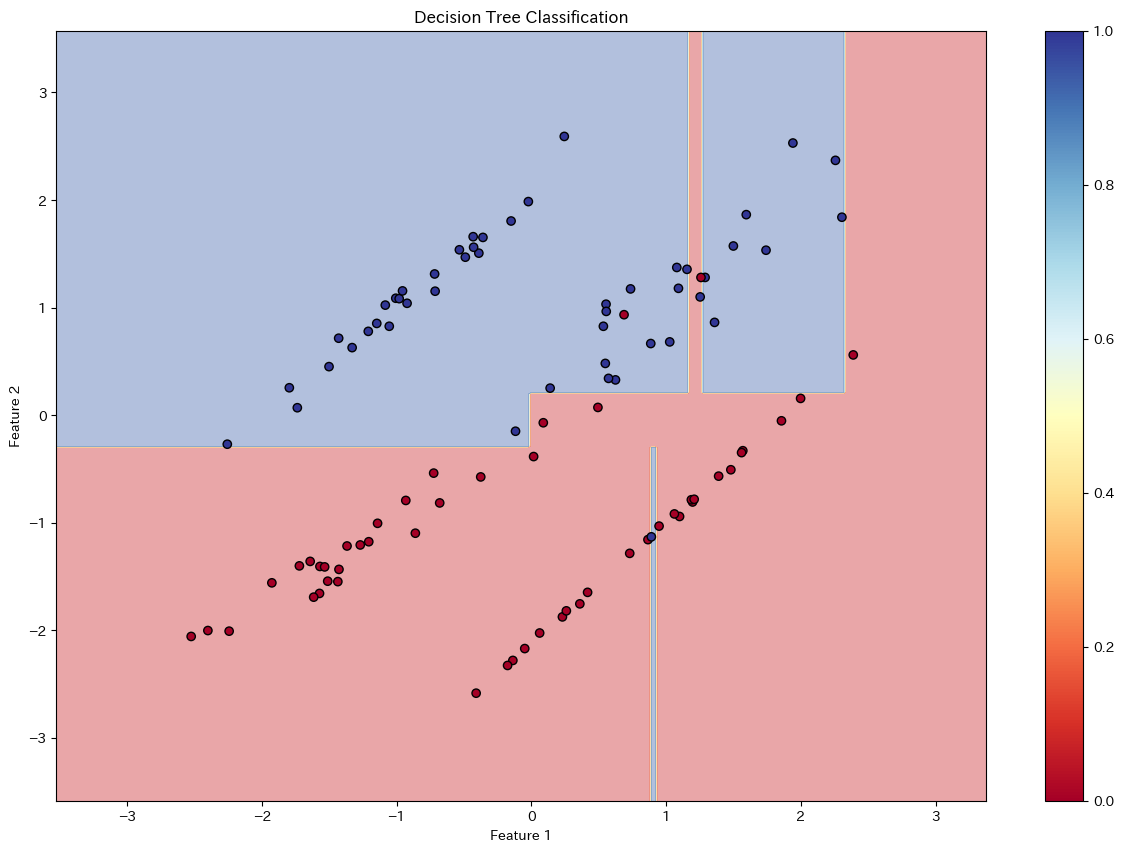

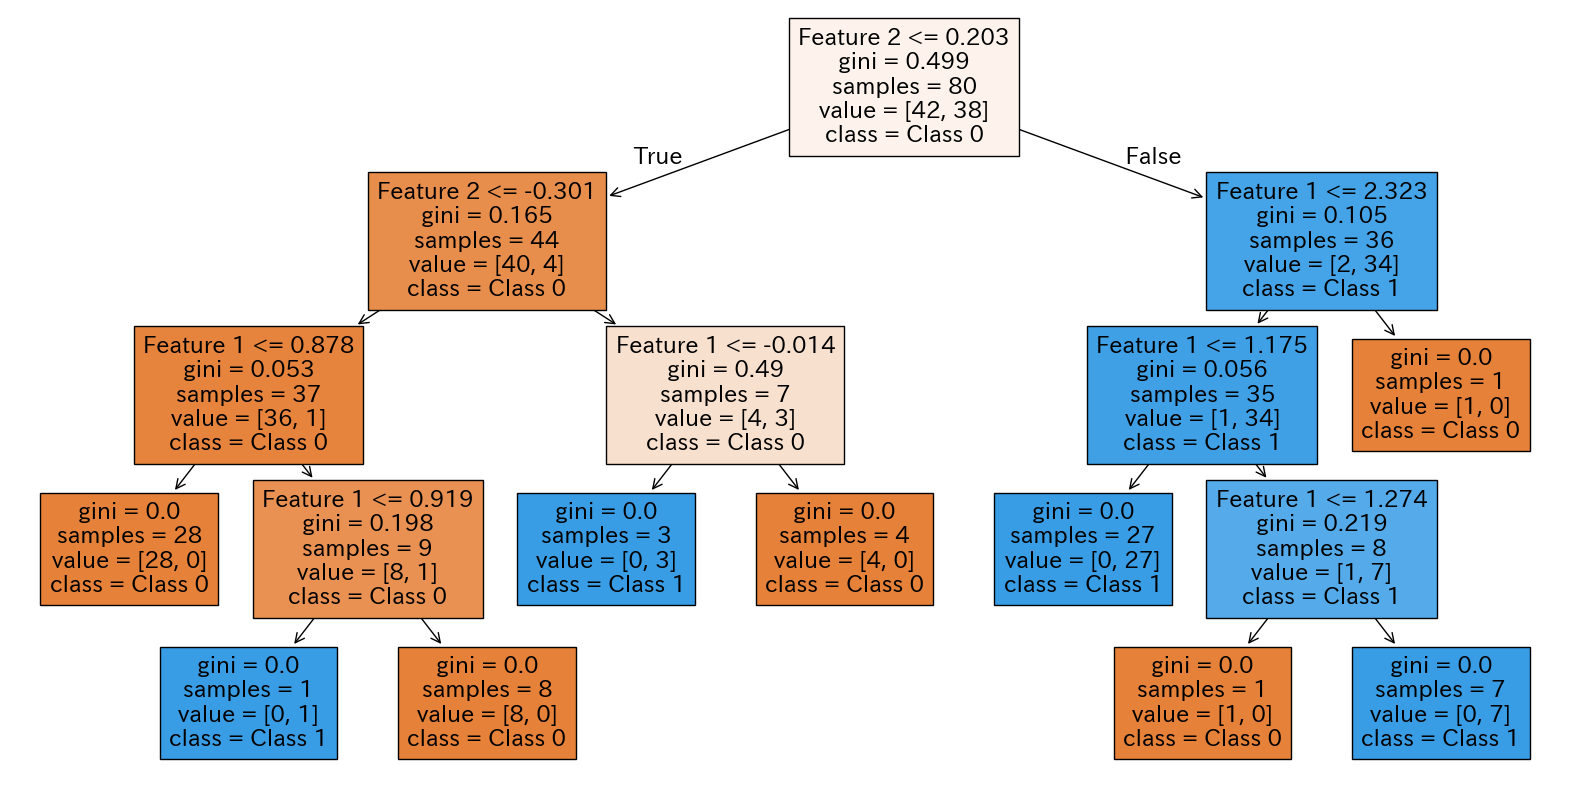

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np

X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42,
                           flip_y=0.03)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 決定木モデルの作成と学習
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# テストデータでの予測
y_pred = clf.predict(X_test)

# 精度の計算
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# データポイントと決定境界の可視化
plt.figure(figsize=(15,10))

# 決定境界の描画
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# データポイントの描画
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolor='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Tree Classification')
plt.colorbar(scatter)

# 決定木の可視化
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=['Feature 1', 'Feature 2'], class_names=['Class 0', 'Class 1'])

plt.show()

このプログラムでは、`sklearn.tree`モジュールから`DecisionTreeRegressor`をインポートし、
以下の手順で決定木を実装しています。

1. サンプルデータを生成
2. データを訓練セットとテストセットに分割
3. 決定木モデルを作成し、訓練データで学習
4. テストデータで予測を行い、精度を計算
5. 学習した決定木を可視化

この例では、2つの特徴量を持つ二値分類問題を扱っています。
実際のデータセットでは、より多くの特徴量や複雑な構造を持つ可能性がありますが、基本的なアプローチは同じです。

決定木は直感的で解釈しやすいモデルですが、適切な使用にはハイパーパラメータの調整（木の深さの制限、最小サンプル数の設定など）が重要です。
また、より高度なアンサンブル手法（ランダムフォレストやグラディエントブースティング）と組み合わせると、より高い性能を得られます。

`scikit-learn`の決定木では、デフォルトでジニ不純度が使用されますが、`criterion`パラメータを`entropy`に設定すれば
エントロピーを使用できます。

線形回帰との主な違いは以下の点です。

- モデルの作成：`DecisionTreeRegressor`を使用
- 予測結果の可視化：決定木の予測は階段状になるため、細かい間隔で予測を行い、それをプロットしています

## 特徴量の重要度

決定木では、特徴量の重要度を確認できます。
以下のプログラムで特徴量の重要度を見てみましょう。

In [4]:
feature_importance = clf.feature_importances_

feature_names = ['Feature 1', 'Feature 2']
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

importance_df = importance_df.sort_values('importance', ascending=False)

print("Feature Importance:")
print(importance_df)

Feature Importance:
     feature  importance
1  Feature 2    0.770619
0  Feature 1    0.229381


この値は、決定木がデータを分割する際に、どの程度その特徴量を使用したかを示しています。
値が大きいほど、その特徴量が予測に重要だと示しています。
今回のデータでは、Feature2が分類にとってより重要だといえます。

## 木の深さと過学習

決定木は非常に柔軟なモデルであるため、訓練データに過度に適合してしまう（過学習）リスクがあります。
これを制御するため、木の深さや葉の最小サンプル数などのハイパーパラメータを調整します。

以下のプログラムでは、異なる最大深さの決定木モデルを作成し、その性能を比較しています。

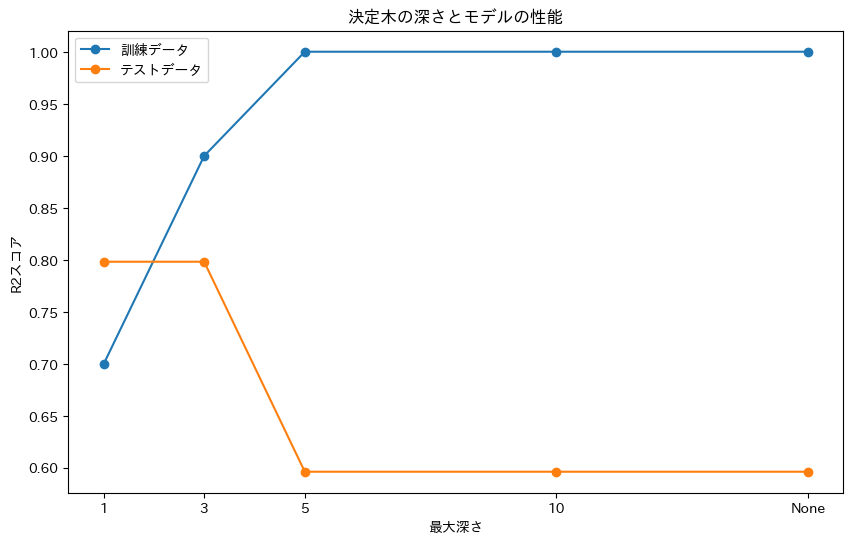

In [5]:
from sklearn.metrics import r2_score

max_depths = [1, 3, 5, 10, None]
train_scores = []
test_scores = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, model.predict(X_train)))
    test_scores.append(r2_score(y_test, model.predict(X_test)))

x_axis = [1, 3, 5, 10, 15]
plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_scores, 'o-', label='訓練データ')
plt.plot(x_axis, test_scores, 'o-', label='テストデータ')
plt.xlabel('最大深さ')
plt.ylabel('R2スコア')
plt.title('決定木の深さとモデルの性能')
plt.legend()

# x軸のラベルを設定
plt.xticks(x_axis, ['1', '3', '5', '10', 'None'])

plt.show()

このグラフから、以下のことが分かります。

- 木の深さが増えるにつれて訓練データに対する性能は向上
- テストデータに対する性能は一定以上深くなるとかえって低下する

これは過学習の典型的な例になります。
決定木の学習では適切な木の深さを選んで過学習を避ける必要があります。

プログラム中の`max_depths`の最後の`None`は、決定木の深さに制限を設けないという意味になります。
`DecisionTreeClassifier`の`max_depth`パラメータに`None`を指定すると、
決定木は制限なく成長し、純粋なノード（全てのサンプルが同じクラスに属するノード）か、
分割によって改善が見られなくなるまで分岐を続けます。

これには以下の意味があります。

- 最大の柔軟性：モデルの潜在的な最大性能を見るのに役立ちます。
- 過学習の観察：制限のない木と制限のある木を比較し、過学習の影響を明確に観察する。
- 最適な深さの探索：様々な深さ（1, 3, 5, 10）と無制限（None）を比較し、最適な深さを見つけるための指針を得る。